In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
import torch
import pickle
import numpy as np
import pandas as pd

In [4]:
path = "/content/drive/MyDrive/AI프로젝트/도서추천/"
matrix_file = "book_vectors_matrix.pkl"

In [5]:
with open(path + matrix_file, "rb") as f:
  matrix = pickle.load(f)
print(matrix.shape)

(621, 768)


In [6]:
df = pd.read_csv(path + "songs_with_tags2.csv", sep="\t")
df.head()

,song_code,song_title,artist,album_cover,album_title,public_date,genre,lyrics,public_date_DV,emotion,singer_code,song_name,singer_name,plylstseq,tag
0,31927275,한 페이지가 될 수 있게,DAY6 (데이식스),https://cdnimg.melon.co.kr/cm/album/images/103...,The Book of Us : Gravity,2019.07.15,록/메탈,솔직히 말할게 많이 기다려 왔어 너도 그랬을 거라 믿어 오늘이 오길 매일같이 달력을...,2020,기쁨,894864,한 페이지가 될 수 있게,DAY6 (데이식스),506070970//462790646//535604305//502268707//52...,댄스//드라이브//신나는//여행//케이팝//아이돌//kpop//드라이브//여행//그...
1,37023625,비의 랩소디,임재현,https://cdnimg.melon.co.kr/cm2/album/images/11...,비의 랩소디,2023.12.03,발라드,이젠 눈물 그쳐 나를 봐요 우는 그대 더 아름다워 내게 이 모습조차 더 남지 않도록...,2020,슬픔,2087273,비의 랩소디,임재현,457536543//534972865//457505963//405075509//53...,발라드//감성//카페//명곡//가요//까페//국내//발라드//봄//발라드//카페//...
2,36382580,헤어지자 말해요,박재정,https://cdnimg.melon.co.kr/cm2/album/images/11...,1집 Alone,2023.04.20,발라드,헤어지자고 말하려 오늘 너에게 가다가 우리 추억 생각해 봤어 처음 본 네 얼굴 마주...,2020,슬픔,738480,헤어지자 말해요,박재정,457536543//100098236//534972865//457505963//48...,발라드//감성//카페//명곡//가요//까페//국내//발라드//추억//명곡//스트레스...
3,4446485,너의 모든 순간,성시경,https://cdnimg.melon.co.kr/cm/album/images/022...,별에서 온 그대 OST Part.7,2014.02.12,발라드,이윽고 내가 한눈에 너를 알아봤을 때 모든 건 분명 달라지고 있었어 내 세상은 널 ...,2010,기쁨,3305,너의 모든 순간,성시경,457536543//534972865//457505963//527521183//50...,발라드//감성//카페//명곡//가요//까페//국내//발라드//봄//발라드//카페//...
4,31666417,주저하는 연인들을 위해,잔나비,https://cdnimg.melon.co.kr/cm/album/images/102...,전설,2019.03.13,인디음악,나는 읽기 쉬운 마음이야 당신도 스윽 훑고 가셔요 달랠 길 없는 외로운 마음 있지 ...,2020,슬픔,772253,주저하는 연인들을 위해,잔나비,534972865//521849384//457536706//401872364//53...,발라드//봄//인디//인디//가요//국내//인디//밤//최신가요//겨울//따뜻한//...


In [7]:
song_title = df.song_title.to_list()
song_title[:5]

['한 페이지가 될 수 있게', '비의 랩소디', '헤어지자 말해요', '너의 모든 순간', '주저하는 연인들을 위해']

In [8]:
title2idx = {}
for i, title in enumerate(song_title):
  title2idx[title] = i

In [9]:
idx2title = {v: k for k, v in title2idx.items()}
idx2emotion = {k: v for k, v in enumerate(df.emotion.tolist())}

In [10]:
df.shape

(621, 15)

# DataLoader

In [11]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

data = torch.from_numpy(matrix).float()
dataset = CustomDataset(data)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

# 데이터 로더 테스트
for batch in dataloader:
    print(batch.shape)  # (batch_size, 768)
    break

torch.Size([16, 768])


In [12]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim=768, latent_dim=2, dropout_rate=0.5):
        super(Autoencoder, self).__init__()

        # 인코더 정의
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, latent_dim)  # Latent space
        )

        # 디코더 정의
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, input_dim)
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            z = self.encode(x)
        return z


In [14]:
import numpy as np
from torch.utils.data import DataLoader, Dataset

# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

(621, 768)


In [15]:
# 손실 함수 정의
def loss_function(recon_x, x):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    return MSE

# 훈련 루프
def train(epoch, dataloader, model, optimizer, scheduler):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, _ = model(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}')
    scheduler.step()

In [16]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

with open(path + matrix_file, "rb") as f:
  matrix = pickle.load(f)
print(matrix.shape)

# 데이터 로더 생성
dataset = CustomDataset(matrix)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

# 모델, 옵티마이저 정의
model = Autoencoder(input_dim=768, latent_dim=2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 모델 훈련
for epoch in range(1, 11):
    train(epoch, dataloader, model, optimizer, scheduler)

(621, 768)
Train Epoch: 1 [0/621 (0%)]	Loss: 164.254105
Train Epoch: 1 [320/621 (53%)]	Loss: 74.470062
====> Epoch: 1 Average loss: 91.9649
Train Epoch: 2 [0/621 (0%)]	Loss: 63.828415
Train Epoch: 2 [320/621 (53%)]	Loss: 67.577209
====> Epoch: 2 Average loss: 63.4406
Train Epoch: 3 [0/621 (0%)]	Loss: 62.373386
Train Epoch: 3 [320/621 (53%)]	Loss: 58.892460
====> Epoch: 3 Average loss: 60.4531
Train Epoch: 4 [0/621 (0%)]	Loss: 63.371086
Train Epoch: 4 [320/621 (53%)]	Loss: 68.803024
====> Epoch: 4 Average loss: 58.6949
Train Epoch: 5 [0/621 (0%)]	Loss: 62.194931
Train Epoch: 5 [320/621 (53%)]	Loss: 53.284836
====> Epoch: 5 Average loss: 55.5763
Train Epoch: 6 [0/621 (0%)]	Loss: 55.533062
Train Epoch: 6 [320/621 (53%)]	Loss: 44.657978
====> Epoch: 6 Average loss: 45.7920
Train Epoch: 7 [0/621 (0%)]	Loss: 42.306183
Train Epoch: 7 [320/621 (53%)]	Loss: 40.983765
====> Epoch: 7 Average loss: 39.5745
Train Epoch: 8 [0/621 (0%)]	Loss: 32.583099
Train Epoch: 8 [320/621 (53%)]	Loss: 36.577545
=

(621, 768)


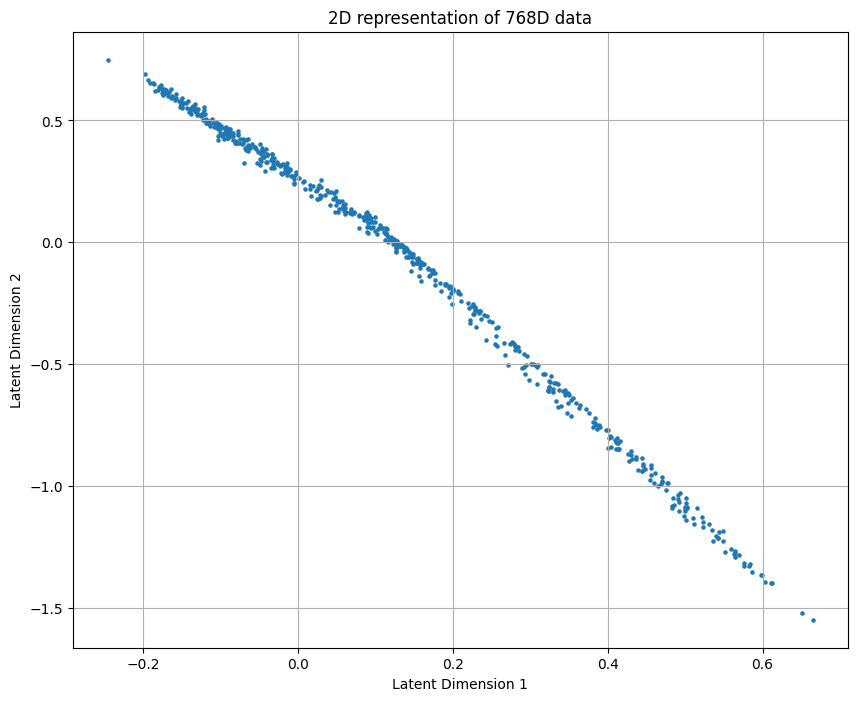

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt

with open(path + matrix_file, "rb") as f:
  matrix = pickle.load(f)
print(matrix.shape)

# 데이터 로더 생성 (훈련이 끝났으므로 배치 크기를 1로 설정)
dataset = CustomDataset(matrix)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# 모델을 GPU에서 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2차원 벡터 저장용 리스트
latent_vectors = []

# 데이터 로더를 통해 데이터 변환
for data in dataloader:
    data = data.to(device)
    latent_vector = model.predict(data)
    latent_vectors.append(latent_vector.cpu().numpy())

# 2차원 벡터로 변환
latent_vectors = np.concatenate(latent_vectors, axis=0)

# 변환된 2차원 벡터 시각화
plt.figure(figsize=(10, 8))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], s=5)
plt.title("2D representation of 768D data")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()


In [18]:
result_df = pd.DataFrame(latent_vectors)
result_df.head()

,0,1
0,0.399857,-0.771056
1,-0.088930,0.465841
2,0.025945,0.221792
3,0.476995,-0.986115
4,0.130117,-0.014059


In [19]:
result_df["idx"] = [i for i in range(result_df.shape[0])]

In [20]:
result_df["emotion"] = result_df["idx"].apply(lambda x: idx2emotion[x])

In [21]:
result_df.head()

,0,1,idx,emotion
0,0.399857,-0.771056,0,기쁨
1,-0.088930,0.465841,1,슬픔
2,0.025945,0.221792,2,슬픔
3,0.476995,-0.986115,3,기쁨
4,0.130117,-0.014059,4,슬픔


In [22]:
result_df.columns = ["0", "1", "idx", "emotion"]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49256 (\N{HANGUL SYLLABLE BBEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49836 (\N{HANGUL SYLLABLE SEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54548 (\N{HANGUL SYLLABLE PEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

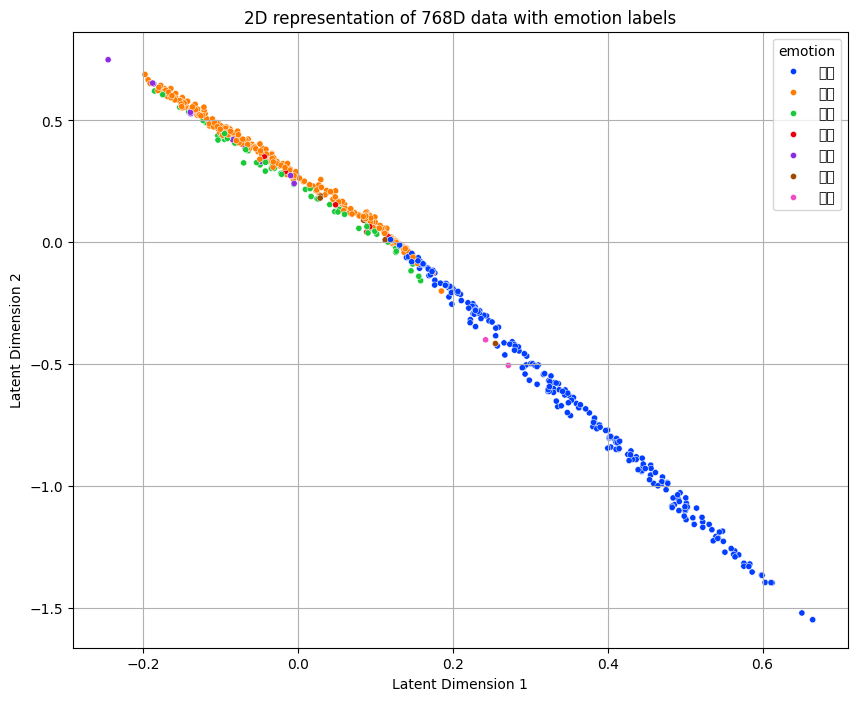

In [23]:
import seaborn as sns
# Seaborn을 사용한 산점도 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(data=result_df, x='0', y='1', hue='emotion', palette='bright', s=20)
plt.title("2D representation of 768D data with emotion labels")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()

In [24]:
df.groupby("emotion").count()

,song_code,song_title,artist,album_cover,album_title,public_date,genre,lyrics,public_date_DV,singer_code,song_name,singer_name,plylstseq,tag
emotion,,,,,,,,,,,,,,
기쁨,245,245,245,245,244,245,245,245,245,245,245,245,245,245
당황,5,5,5,5,5,5,5,5,5,5,5,5,5,5
분노,59,59,59,59,59,59,59,59,59,59,59,59,59,59
불안,7,7,7,7,7,7,7,7,7,7,7,7,7,7
상처,10,10,10,10,10,10,10,10,10,10,10,10,10,10
슬픔,293,293,293,293,293,293,293,293,293,293,293,293,293,293
중립,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [25]:
koremotion2engemotion = {
    "기쁨": "happiness",
    "슬픔": "sadness",
    "분노": "anger",
    "불안": "anxiety",
    "당황": "surprise",
    "상처": "hurt",
    "중립": "neutral"
}
result_df["emotion"] = result_df["emotion"].apply(lambda x: koremotion2engemotion[x])

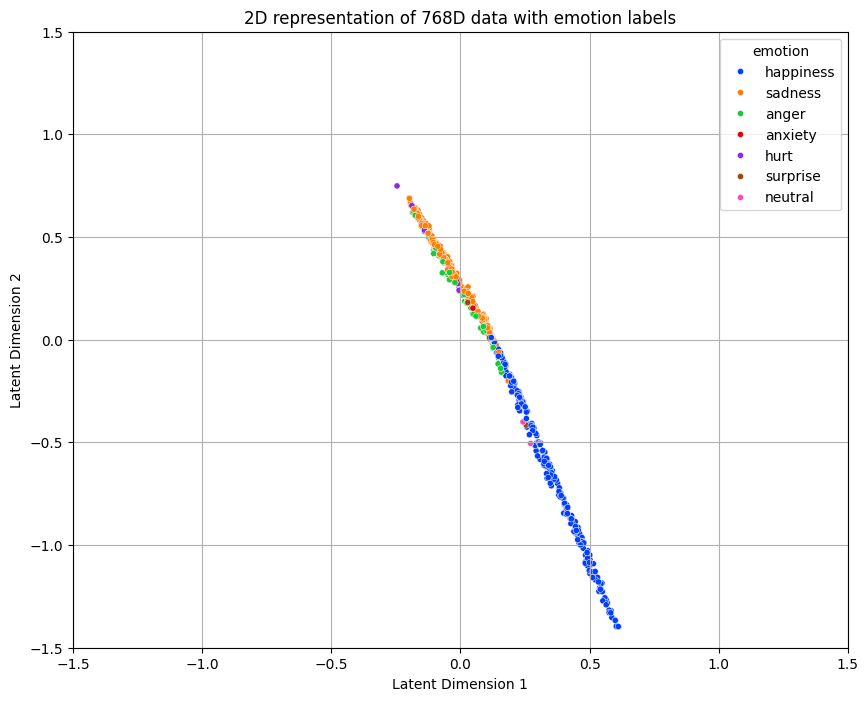

In [28]:
import seaborn as sns
# Seaborn을 사용한 산점도 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(data=result_df, x='0', y='1', hue='emotion', palette='bright', s=20)
plt.title("2D representation of 768D data with emotion labels")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()

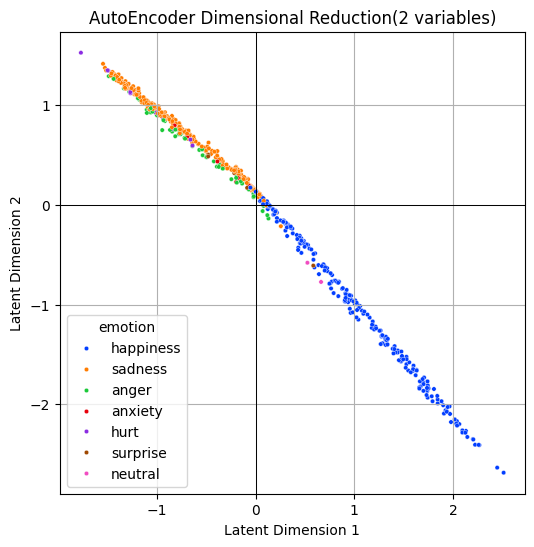

In [36]:
from sklearn.preprocessing import StandardScaler
# PCA 결과 표준화
scaler = StandardScaler()
result_df[['0', '1']] = scaler.fit_transform(result_df[['0', '1']])

# Seaborn을 사용한 산점도 시각화
plt.figure(figsize=(6, 6))
sns.scatterplot(data=result_df, x='0', y='1', hue='emotion', palette='bright', s=10)
plt.title("AutoEncoder Dimensional Reduction(2 variables)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
# x축과 y축에 진한 검은 직선 추가
plt.axhline(y=0, color='black', linewidth=0.7)
plt.axvline(x=0, color='black', linewidth=0.7)
plt.grid(True)
plt.show()